In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import random
import os
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [55]:
class config:
    seed = 42
    lr = 1e-3
    epochs = 50
    batch_size = 64
    num_workers = 2
    train_5_folds = True

    x_dim = 28
    h_dim = 512
    z_dim = 256

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(config.seed)

In [56]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=config.batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=config.batch_size)

In [57]:
# Encoder의 역할은 Variational Inference를 통해 P(z|x)를 근사하는 정규분포와 파라미터를 구하는 것
class Encoder(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(x_dim**2,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.mu = nn.Linear(h_dim,z_dim)
        self.var = nn.Linear(h_dim,z_dim)

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)

        mu = self.mu(x)
        logvar = self.var(x)

        return mu, logvar

In [58]:
# Decoder의 역할은 z로 부터 p(x|g(z)) 분포에 대한 파라미터를 학습
class Bernoulli_Decoder(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(z_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.p = nn.Sequential(
                nn.Linear(h_dim,x_dim**2),
                nn.Sigmoid()
            )


    def forward(self,z):
        z = self.fc1(z)
        z = self.fc2(z)

        p = self.p(z)

        return p

In [59]:
class AutoEncoder(L.LightningModule):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.training_step_loss = []

    def reparameterization_trick(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        sampling = torch.randn_like(mu)

        return mu + std * sampling

    def loss_function(self,x,generate_x,mu,logvar):
        BCE = F.binary_cross_entropy(generate_x, x, reduction = 'sum')
        KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        return BCE + KLD

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization_trick(mu,logvar)
        generate_x = self.decoder(z)

        return mu,logvar,generate_x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=config.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        X = batch[0]

        X = X.view(-1,config.x_dim**2)
        mu, logvar, generate_x = self(X)

        loss = self.loss_function(X,generate_x,mu,logvar)
        self.training_step_loss.append(loss.cpu().detach().numpy())

        self.log('train_loss',loss)

        return loss

    def on_train_epoch_end(self):

        loss = np.mean(self.training_step_loss)
        print(f'epoch: {self.current_epoch} train_loss: {loss}')
        self.training_step_loss.clear()  # free memory

    def predict_step(self, batch, batch_idx):
        X = batch[0]

        flatten = X.view(-1,config.x_dim**2)
        mu,logvar,generate_x = self(flatten)
        recon_X = generate_x.view(-1,1,config.x_dim,config.x_dim)

        return X,recon_X

In [60]:
encoder = Encoder(config.x_dim,config.h_dim,config.z_dim)
decoder = Bernoulli_Decoder(config.x_dim,config.h_dim,config.z_dim)
autoencoder = AutoEncoder(encoder,decoder)

In [61]:
trainer = L.Trainer(max_epochs=config.epochs)
trainer.fit(autoencoder,train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type              | Params
----------------------------------------------
0 | encoder | Encoder           | 927 K 
1 | decoder | Bernoulli_Decoder | 796 K 
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.895     Total estimated model params size (MB)
INFO:lightning.

Training: 0it [00:00, ?it/s]

epoch: 0 train_loss: 11836.8525390625
epoch: 1 train_loss: 10011.8173828125
epoch: 2 train_loss: 9274.21875
epoch: 3 train_loss: 8669.396484375
epoch: 4 train_loss: 8318.9833984375
epoch: 5 train_loss: 8118.263671875
epoch: 6 train_loss: 7986.95263671875
epoch: 7 train_loss: 7912.03955078125
epoch: 8 train_loss: 7859.23388671875
epoch: 9 train_loss: 7818.31005859375
epoch: 10 train_loss: 7784.38525390625
epoch: 11 train_loss: 7761.87109375
epoch: 12 train_loss: 7735.45166015625
epoch: 13 train_loss: 7718.23046875
epoch: 14 train_loss: 7702.85302734375
epoch: 15 train_loss: 7690.849609375
epoch: 16 train_loss: 7672.14794921875
epoch: 17 train_loss: 7659.55029296875
epoch: 18 train_loss: 7651.953125
epoch: 19 train_loss: 7645.47021484375
epoch: 20 train_loss: 7637.13623046875
epoch: 21 train_loss: 7626.548828125
epoch: 22 train_loss: 7618.54150390625
epoch: 23 train_loss: 7613.22900390625
epoch: 24 train_loss: 7609.3671875
epoch: 25 train_loss: 7595.79541015625
epoch: 26 train_loss: 7590

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch: 49 train_loss: 7510.25146484375


In [62]:
output = trainer.predict(autoencoder,test_loader,ckpt_path='last')

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [63]:
def show_adn_save(file_name,img):
    """
    이미지 출력해주고 세이브 해주는 역할의 함수
    """
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)



real_test


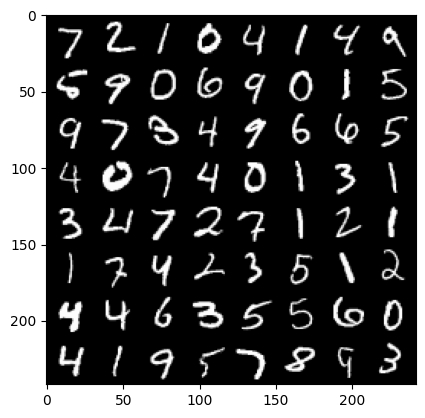

In [66]:
print('real_test')
show_adn_save('real_test_data',make_grid(output[0][0].view(64,1,28,28).data))

recon_test


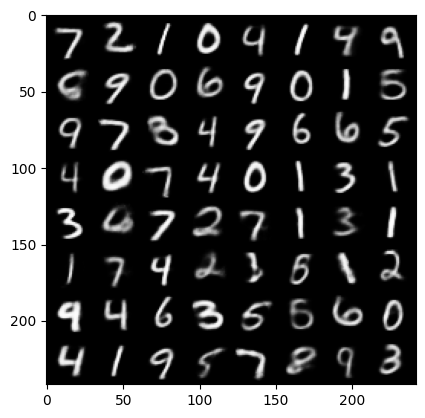

In [67]:
print('recon_test')
show_adn_save('reconstruct_test_data',make_grid(output[0][1].view(64,1,28,28).data))